In [1]:
import polars as pl

MalwareDataset = pl.read_csv(
    "../data/MalwareData.csv",
    separator='|',
    schema_overrides={
        "ImageBase": pl.UInt64 # Use unsigned 64-bit integer
    }
)

In [2]:
import numpy as np
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import model_selection

In [3]:
MalwareDataset_drop = MalwareDataset.drop(["Name", "md5", "legitimate"]) # legitimate is target
X = MalwareDataset_drop

In [4]:
y = MalwareDataset["legitimate"]

## Selecting features

In [5]:
# ExtraTreesClassifier
FeatSelect = ExtraTreesClassifier().fit(X, y)
Model = SelectFromModel(FeatSelect, prefit=True)
feature_idx = Model.get_support()
feature_name = X[feature_idx].columns

In [6]:
X = Model.transform(X)

/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [7]:
X = pl.DataFrame(X)
X.columns = feature_name

## Gradient Boosting Method

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import optuna

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [10]:
class Objective_GBC:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __call__(self, trial):
        params = {
            "max_depth":     trial.suggest_int("max_depth", 3, 10),
            "max_features":  trial.suggest_categorical("max_features", ["log2", "sqrt"]),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-0),
            "criterion":     trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"])
        }
        model = GradientBoostingClassifier(**params)
        scores = cross_validate(
            model,
            X=self.X,
            y=self.y,
            cv=5,
            n_jobs=-1,
        )
        return scores["test_score"].mean()

In [11]:
objective = Objective_GBC(X_train, y_train)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

[I 2024-10-08 01:11:50,951] A new study created in memory with name: no-name-201f2129-119f-41e1-951e-474654b12557
/tmp/ipykernel_30881/2878854718.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-0),
[I 2024-10-08 01:12:05,704] Trial 0 finished with value: 0.990908844935704 and parameters: {'max_depth': 5, 'max_features': 'log2', 'learning_rate': 0.10682644356734664, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.990908844935704.


In [12]:
print(study.best_params)

{'max_depth': 5, 'max_features': 'log2', 'learning_rate': 0.10682644356734664, 'criterion': 'friedman_mse'}


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [14]:
model = GradientBoostingClassifier(
    **study.best_params
)

In [15]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Accuracy: {}".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 99.16334661354583
[[19122   128]
 [  103  8257]]


In [16]:
feat_importance = pl.DataFrame({
    "feature": X.columns,
    "feature importance": model.feature_importances_ 
}).sort("feature importance")

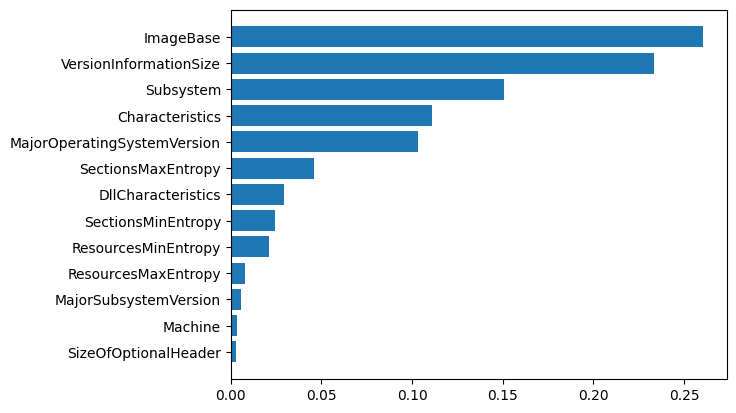

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.barh(feat_importance["feature"], feat_importance["feature importance"], align='center')
plt.show()